<a href="https://colab.research.google.com/github/AnIsAsPe/LogisticRegression_SpamOpinion/blob/master/Notebooks/Clasificador_rese%C3%B1as_multiclase_Regresi%C3%B3n_log%C3%ADstica_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer  ## SnowballStemmer (para español)

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Funciones

In [2]:
STOPWORDS_RGX = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

def elimina_stopwords(texto):
  '''
  Quitar todas las palabras palabras vacias (stopwords)
  '''
  nuevo_texto = STOPWORDS_RGX.sub('', texto)
  return nuevo_texto

# https://www.regular-expressions.info/index.html
# https://www.tutorialspoint.com/Why-do-we-use-re-compile-method-in-Python-regular-expression

In [3]:
stopwords.words('english')

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [4]:
elimina_stopwords("I love how you cook".lower())

'love cook'

In [5]:
SOLO_LETRAS_RGX = re.compile(r'[^a-z]+')

def elimina_puntuacion_y_numeros(texto):
  """
  Elimina todo lo que no sea letras minúsculas.
  """
  return SOLO_LETRAS_RGX.sub(' ', texto)


In [6]:
elimina_puntuacion_y_numeros("Is he 8 years old?".lower())

'is he years old '

In [7]:
"Is he 8 years old?".split()

['Is', 'he', '8', 'years', 'old?']

In [8]:
lemma = WordNetLemmatizer()
def lematizar(texto):
  '''
  Lematiza las palabras, enfocandose en los verbos
  '''
  texto = texto.split()
  nuevo_texto = " ".join([lemma.lemmatize(i, 'v') for i in texto])
  return nuevo_texto

# para un mejor funcionamiento necesita saber el tipo de palabra por lo que se
# recomienda usar antes pos_tag

In [9]:
lematizar("ran run running")

'run run run'

In [10]:
st = PorterStemmer()                  # para inglés
# st = SnowballStemmer("spanish")     # para español

def stemmer(texto):
  texto = texto.split()
  nuevo_texto = ' '.join([st.stem(i) for i in texto])
  return nuevo_texto

In [11]:
stemmer("ran run running")

'ran run run'

In [12]:
def preprocesar(texto):
  texto = texto.lower()
  texto = elimina_stopwords(texto)
  texto = elimina_puntuacion_y_numeros(texto)
  texto = stemmer(texto)
  return(texto)


In [13]:
def evaluacion(modelo, graph_size=(10, 4)):
  """
  Evalúa el modelo tanto en el conjunto de entrenamiento como en el de prueba
  y muestra las matrices de confusión para ambos in a row.

  Args:
    modelo: El modelo entrenado a evaluar.
    graph_size: The size of the figure for the heatmaps.
  """

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(graph_size[0], graph_size[1]))

  # Evaluar en el conjunto de entrenamiento
  accuracy = modelo.score(X_train, y_train) * 100

  data = {'y_Real': y_train, 'y_Prediccion': modelo.predict(X_train)}
  df = pd.DataFrame(data, columns=['y_Real', 'y_Prediccion'])
  confusion_matrix_train = pd.crosstab(df['y_Real'],
                                       df['y_Prediccion'],
                                       rownames=['Real'],
                                       colnames=['Predicción'])
  sns.heatmap(
      confusion_matrix_train,
      annot=True, fmt='g', ax=ax1
      ).set(title='df_train: entrenamiento, accuracy = {:4.2f}'.format(accuracy))

  # Evaluar en el conjunto de prueba
  accuracy = modelo.score(X_test, y_test) * 100

  data = {'y_Real': y_test, 'y_Prediccion': modelo.predict(X_test)}
  df = pd.DataFrame(data, columns=['y_Real', 'y_Prediccion'])
  confusion_matrix_test = pd.crosstab(df['y_Real'],
                                      df['y_Prediccion'],
                                      rownames=['Real'],
                                      colnames=['Predicción'])
  sns.heatmap(
      confusion_matrix_test,
      annot=True, fmt='g', ax=ax2
      ).set(title='df_train: prueba, accuracy = {:4.2f}'.format(accuracy))
  plt.tight_layout()
  plt.show()

# 1.Lectura de df_train

In [14]:
df = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/LogisticRegression_SpamOpinion/refs/heads/master/Datos/deceptive-opinion.csv',
                     usecols=['deceptive','polarity', 'text']
                    )
display(df.shape, df.head())


(1600, 3)

,deceptive,polarity,text
0,truthful,positive,We stayed for a one night getaway with family ...
1,truthful,positive,Triple A rate with upgrade to view room was le...
2,truthful,positive,This comes a little late as I'm finally catchi...
3,truthful,positive,The Omni Chicago really delivers on all fronts...
4,truthful,positive,I asked for a high floor away from the elevato...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   object
 1   polarity   1600 non-null   object
 2   text       1600 non-null   object
dtypes: object(3)
memory usage: 37.6+ KB


In [16]:
pd.crosstab(df['deceptive'], df['polarity'])

polarity,negative,positive
deceptive,,
deceptive,400,400
truthful,400,400


# 2.División Inicial Train/Test

In [17]:
df_train, df_test = train_test_split(df,
                                     test_size=0.20,
                                     shuffle=True,
                                     random_state=8,
                                     stratify=df[['deceptive','polarity']])

print("Registros en Train:", len(df_train))
print("Registros en Test:", len(df_test))



Registros en Train: 1280
Registros en Test: 320


# 3.Exploración y preprocesamiento train

In [18]:
display(
     df_train['polarity'].value_counts(),
     df_train['deceptive'].value_counts()
)

,count
polarity,
negative,640
positive,640


,count
deceptive,
truthful,640
deceptive,640


In [19]:
df_train['text']

,text
1186,Stayed in old tower. Room was nice and room se...
251,Excellent service! Clean and spacious rooms wi...
1426,My husband and I stayed here at the Hard Rock ...
740,This was my first time in Chicago and I tell y...
1431,I recently stayed at the Hard Rock Hotel in Ch...
...,...
350,Spent a wonderful night at the Amalfi with fri...
1521,My daughter wanted to spend the weekend in Chi...
1468,When I made my reservations at Softiel in Chic...
158,everything that i read from other reviews was ...


In [20]:
df_train['long_text'] = df_train['text'].str.split().str.len()
df_train

,deceptive,polarity,text,long_text
1186,truthful,negative,Stayed in old tower. Room was nice and room se...,138
251,truthful,positive,Excellent service! Clean and spacious rooms wi...,37
1426,deceptive,negative,My husband and I stayed here at the Hard Rock ...,81
740,deceptive,positive,This was my first time in Chicago and I tell y...,104
1431,deceptive,negative,I recently stayed at the Hard Rock Hotel in Ch...,49
...,...,...,...,...
350,truthful,positive,Spent a wonderful night at the Amalfi with fri...,38
1521,deceptive,negative,My daughter wanted to spend the weekend in Chi...,206
1468,deceptive,negative,When I made my reservations at Softiel in Chic...,221
158,truthful,positive,everything that i read from other reviews was ...,172


In [21]:
df_train['long_text'].describe()

,long_text
count,1280.000000
mean,148.719531
std,88.118897
min,25.000000
25%,87.750000
50%,128.500000
75%,183.000000
max,784.000000


## Preprocesamiento de texto

In [22]:
indice = 1473
ejemplo = df_train.loc[indice, 'text']
ejemplo

"For a hotel rated with four diamonds by AAA, one would think the Hilton Chicago would be almost like staying at a palace with royalty. The only royal thing about this hotel however is that it was a royal nightmare. I should have known from the moment I walked in with my wife that this was going to become a bigger headache than what it was worth. First off, as soon as we arrived to check in at the hotel with the clerk who couldn't be any older than nineteen or twenty, red flags started going up. The clerk was extremely rude and lazy, acting like it was a chore even getting up from texting on his cell phone. If that wasn't bad enough, the clerk pretty much ignored me while blatantly staring at my wife's breasts. She wasn't even wearing anything that could be considered skimpy as it was cold out and she was wearing a turtle neck sweater under a large fur lined coat. After diverting his atention several times we finally got our room keys. It shouldn't have been any surprise when we learne

<h3> Transformar texto a minúsculas

In [23]:
ejemplo = ejemplo.lower()
ejemplo

"for a hotel rated with four diamonds by aaa, one would think the hilton chicago would be almost like staying at a palace with royalty. the only royal thing about this hotel however is that it was a royal nightmare. i should have known from the moment i walked in with my wife that this was going to become a bigger headache than what it was worth. first off, as soon as we arrived to check in at the hotel with the clerk who couldn't be any older than nineteen or twenty, red flags started going up. the clerk was extremely rude and lazy, acting like it was a chore even getting up from texting on his cell phone. if that wasn't bad enough, the clerk pretty much ignored me while blatantly staring at my wife's breasts. she wasn't even wearing anything that could be considered skimpy as it was cold out and she was wearing a turtle neck sweater under a large fur lined coat. after diverting his atention several times we finally got our room keys. it shouldn't have been any surprise when we learne

<h3> Quitar puntuación

In [24]:
ejemplo = elimina_puntuacion_y_numeros(ejemplo)
ejemplo

'for a hotel rated with four diamonds by aaa one would think the hilton chicago would be almost like staying at a palace with royalty the only royal thing about this hotel however is that it was a royal nightmare i should have known from the moment i walked in with my wife that this was going to become a bigger headache than what it was worth first off as soon as we arrived to check in at the hotel with the clerk who couldn t be any older than nineteen or twenty red flags started going up the clerk was extremely rude and lazy acting like it was a chore even getting up from texting on his cell phone if that wasn t bad enough the clerk pretty much ignored me while blatantly staring at my wife s breasts she wasn t even wearing anything that could be considered skimpy as it was cold out and she was wearing a turtle neck sweater under a large fur lined coat after diverting his atention several times we finally got our room keys it shouldn t have been any surprise when we learned that there 

<h3> Quitar Palabras Irrelevantes ("Stopwords")

In [25]:
ejemplo = elimina_stopwords(ejemplo)
ejemplo

'hotel rated four diamonds aaa one would think hilton chicago would almost like staying palace royalty royal thing hotel however royal nightmare known moment walked wife going become bigger headache worth first soon arrived check hotel clerk older nineteen twenty red flags started going clerk extremely rude lazy acting like chore even getting texting cell phone bad enough clerk pretty much ignored blatantly staring wife breasts even wearing anything could considered skimpy cold wearing turtle neck sweater large fur lined coat diverting atention several times finally got room keys surprise learned one help us luggage clerk said break okay annoying managed easy enough finally got third floor suite reserved month looked forward resting long trip surprise mention disgust horror already couple supposed room bed making took almost half hour couple room front desk wife get straightened apparently night clerk bother following policy taken reservation computer give friends leaving printed card 

<h3> Normalización
Existen dos principales técnicas para normalizar el texto, la lematización y "radicalización" o stemming, que consiste en la  conversión de palabras en las raices

Referencia:

https://towardsdatascience.com/introduction-to-nlp-part-2-difference-between-lemmatisation-and-stemming-3789be1c55bc

In [26]:
ejemplo_lema = lematizar(ejemplo)
ejemplo_lema

'hotel rat four diamonds aaa one would think hilton chicago would almost like stay palace royalty royal thing hotel however royal nightmare know moment walk wife go become bigger headache worth first soon arrive check hotel clerk older nineteen twenty red flag start go clerk extremely rude lazy act like chore even get texting cell phone bad enough clerk pretty much ignore blatantly star wife breast even wear anything could consider skimpy cold wear turtle neck sweater large fur line coat divert atention several time finally get room key surprise learn one help us luggage clerk say break okay annoy manage easy enough finally get third floor suite reserve month look forward rest long trip surprise mention disgust horror already couple suppose room bed make take almost half hour couple room front desk wife get straighten apparently night clerk bother follow policy take reservation computer give friends leave print card day clerk could describe chaos finally give another room next floor th

In [27]:
ejemplo_stem = stemmer(ejemplo)
ejemplo_stem

'hotel rate four diamond aaa one would think hilton chicago would almost like stay palac royalti royal thing hotel howev royal nightmar known moment walk wife go becom bigger headach worth first soon arriv check hotel clerk older nineteen twenti red flag start go clerk extrem rude lazi act like chore even get text cell phone bad enough clerk pretti much ignor blatantli stare wife breast even wear anyth could consid skimpi cold wear turtl neck sweater larg fur line coat divert atent sever time final got room key surpris learn one help us luggag clerk said break okay annoy manag easi enough final got third floor suit reserv month look forward rest long trip surpris mention disgust horror alreadi coupl suppos room bed make took almost half hour coupl room front desk wife get straighten appar night clerk bother follow polici taken reserv comput give friend leav print card day clerk could describ chao final given anoth room next floor thank got wife went use bathroom drop luggag bed hear cl

<h3> Todo junto

In [28]:
df_train['text_pp'] = df_train['text'].apply(preprocesar)
df_train['long_text_pp'] = df_train['text_pp'].str.split().str.len()
df_train.head()

,deceptive,polarity,text,long_text,text_pp,long_text_pp
1186,truthful,negative,Stayed in old tower. Room was nice and room se...,138,stay old tower room nice room servic good room...,72
251,truthful,positive,Excellent service! Clean and spacious rooms wi...,37,excel servic clean spaciou room great view dow...,23
1426,deceptive,negative,My husband and I stayed here at the Hard Rock ...,81,husband stay hard rock hotel chicago month bac...,33
740,deceptive,positive,This was my first time in Chicago and I tell y...,104,first time chicago tell realli made feel like ...,45
1431,deceptive,negative,I recently stayed at the Hard Rock Hotel in Ch...,49,recent stay hard rock hotel chicago il start e...,22


## Visualización de nubes de palabras

In [29]:
def nube_palabras(sec_textos):
    # Crear la cadena con la que haremos la nube de palabras
    text= " ".join(review for review in sec_textos)

    # Crear la nube de palabras
    wordcloud = WordCloud( max_font_size=50,
                          max_words=100,
                          background_color="white").generate(text)

    # Desplegar la imagen generada
    plt.figure(figsize=[10,12])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

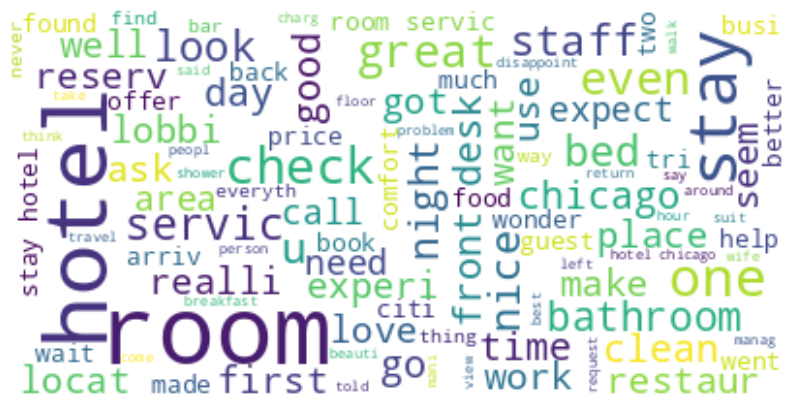

In [30]:
nube_palabras(df_train['text_pp'])

In [31]:
porClase = df_train.groupby('deceptive')
verdaderas = porClase.get_group('truthful').text_pp
falsas = porClase.get_group('deceptive').text_pp

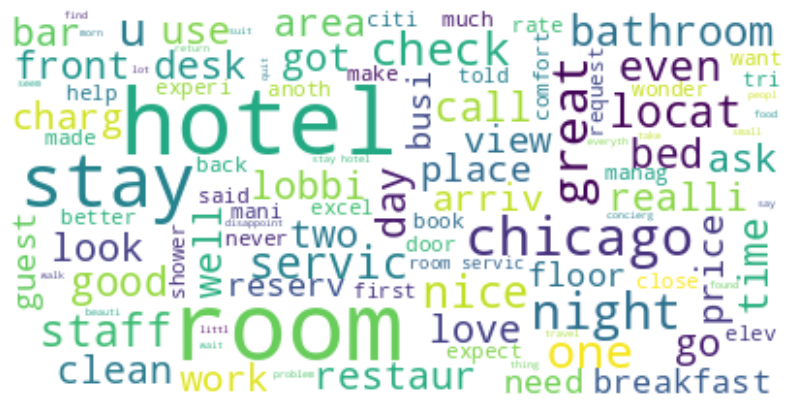

In [32]:
nube_palabras(verdaderas)

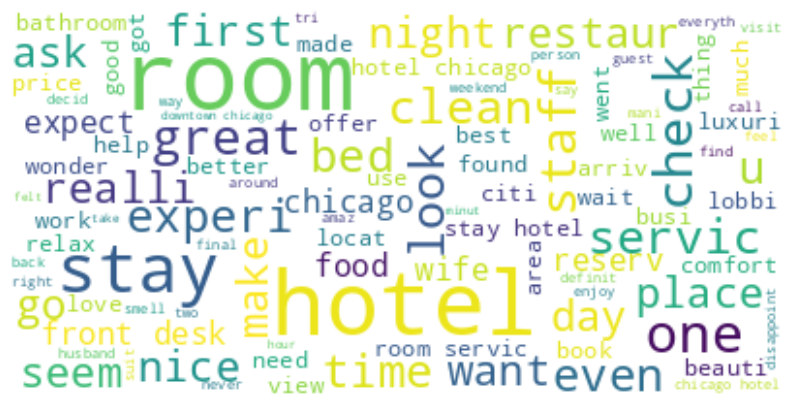

In [33]:
nube_palabras(falsas)

## Vectorización de Texto mediante BOW

In [34]:
vectorizer = TfidfVectorizer(min_df=2)
X_train = vectorizer.fit_transform(df_train['text_pp'])
X_train.shape

(1280, 3278)

In [35]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 73453 stored elements and shape (1280, 3278)>

In [36]:
features_names = vectorizer.get_feature_names_out()
X_train = pd.DataFrame(X_train.todense(), index=df_train.index, columns=features_names)
X_train

,aaa,abil,abl,abrupt,absent,absolut,absurd,abund,abysm,ac,...,yogurt,york,young,younger,yuck,yummi,yup,zest,zone,zoo
1186,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1426,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
740,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1431,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1521,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1468,0.0,0.0,0.0,0.159099,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
y_train = df_train['deceptive']

# 4.Preprocesamiento test


In [38]:
# Preprocesamiento Texto
df_test['text_pp'] = df_test['text'].apply(preprocesar)

# Vectorizar
X_test= vectorizer.transform(df_test['text_pp'])
X_test = pd.DataFrame(X_test.todense(), index=df_test.index, columns=features_names)
X_test.shape

(320, 3278)

In [39]:
y_test = df_test['deceptive']

# 5.Regresión Logística sin penalización

In [40]:
clasificador_rl = LogisticRegression(penalty= None,
                                     random_state=4,
                                     max_iter=1500,        # Default 100
                                     tol=0.0001,           # Default 1e-4
                                     solver="sag").fit(X_train, y_train)

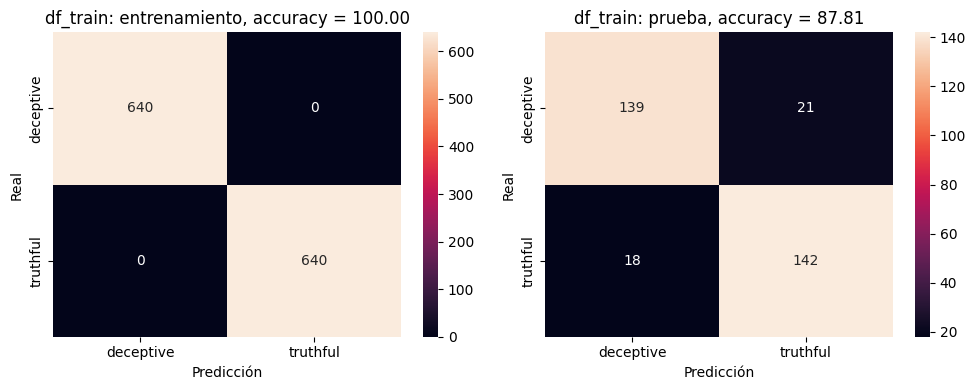

In [41]:
evaluacion(modelo=clasificador_rl)

# 6.Regresión Logística con penalización Ridge

## ¿De qué magnitud debe ser la fueza de la regularización (λ)? (Búsqueda de hiperparametros)


In [42]:
%%time
from sklearn.model_selection import KFold, GridSearchCV

lambdas = np.array([0.1, 1, 5, 10, 100]) # np.logspace(-3, 3, 25)

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

regresion_ridge = LogisticRegression(penalty='l2',
                              solver="sag",
                              max_iter=1500,
                              tol=0.0001,
                              warm_start=True)

grid_search = GridSearchCV(estimator = regresion_ridge,
                           param_grid={'C': 1/lambdas},
                           cv= kf,   # estrategia de separación del conjunto de df_train
                           return_train_score=True)
grid_search.fit(X_train, y_train)

CPU times: user 44.5 s, sys: 50.5 ms, total: 44.6 s
Wall time: 42.3 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1500, solver='sag',
                                          warm_start=True),
             param_grid={'C': array([10.  ,  1.  ,  0.2 ,  0.1 ,  0.01])},
             return_train_score=True)

In [43]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.925623,0.297328,0.019952,0.004309,10.00,{'C': 10.0},0.875000,0.863281,0.859375,0.898438,...,0.875781,0.014063,1,1.000000,0.999023,0.999023,0.999023,1.000000,0.999414,0.000478
1,1.856475,0.353906,0.023930,0.007026,1.00,{'C': 1.0},0.882812,0.863281,0.835938,0.890625,...,0.871875,0.020282,2,0.971680,0.965820,0.972656,0.967773,0.977539,0.971094,0.004078
2,1.141669,0.079036,0.017747,0.000164,0.20,{'C': 0.2},0.859375,0.843750,0.812500,0.886719,...,0.856250,0.026540,3,0.942383,0.928711,0.941406,0.937500,0.947266,0.939453,0.006207
3,1.327660,0.429047,0.021080,0.005670,0.10,{'C': 0.1},0.855469,0.800781,0.812500,0.875000,...,0.842969,0.030599,4,0.930664,0.899414,0.923828,0.919922,0.932617,0.921289,0.011858
4,1.263880,0.108982,0.017891,0.000184,0.01,{'C': 0.01},0.871094,0.433594,0.460938,0.527344,...,0.621875,0.184521,5,0.912109,0.517578,0.540039,0.584961,0.886719,0.688281,0.173935


In [44]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['param_C', 'mean_train_score', 'mean_test_score',]]

,param_C,mean_train_score,mean_test_score
0,10.00,0.999414,0.875781
1,1.00,0.971094,0.871875
2,0.20,0.939453,0.856250
3,0.10,0.921289,0.842969
4,0.01,0.688281,0.621875


In [45]:
C_best = grid_search.best_params_['C']

In [46]:
C_best

np.float64(10.0)

In [47]:
clasificador_ridge = LogisticRegression(penalty= 'l2',
                                        C = C_best,
                                        solver="saga",
                                        max_iter=1500,
                                        tol=0.0001,
                                        warm_start=True,
                                        random_state=4).fit(X_train, y_train)

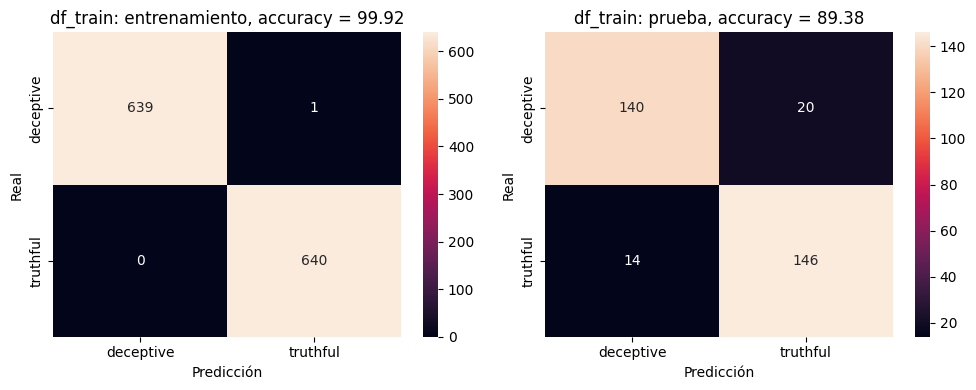

In [48]:
evaluacion(clasificador_ridge)

## Predicciones y certeza de la predicción

In [49]:
clasificador_ridge.classes_

array(['deceptive', 'truthful'], dtype=object)

In [50]:
clasificador_ridge.predict(X_test)[:10]

array(['deceptive', 'deceptive', 'truthful', 'truthful', 'truthful',
       'truthful', 'deceptive', 'deceptive', 'truthful', 'truthful'],
      dtype=object)

In [51]:
clasificador_ridge.predict_proba(X_test)[:10]

array([[0.54672938, 0.45327062],
       [0.99633555, 0.00366445],
       [0.16731141, 0.83268859],
       [0.00851783, 0.99148217],
       [0.00892265, 0.99107735],
       [0.40263946, 0.59736054],
       [0.93874566, 0.06125434],
       [0.6144547 , 0.3855453 ],
       [0.04156138, 0.95843862],
       [0.47077471, 0.52922529]])

In [52]:
resultados = {'P(deceptive)' : clasificador_ridge.predict_proba(X_test)[:,0],
              'P(truthful)' : clasificador_ridge.predict_proba(X_test)[:,1],
              'y_pred_50' : clasificador_ridge.predict(X_test),
              }

predicciones = pd.DataFrame(resultados)
predicciones.sort_values('P(deceptive)',
                         ascending=False).iloc[125:165]

,P(deceptive),P(truthful),y_pred_50
153,0.674023,0.325977,deceptive
199,0.663404,0.336596,deceptive
80,0.660095,0.339905,deceptive
145,0.659314,0.340686,deceptive
22,0.653749,0.346251,deceptive
250,0.650719,0.349281,deceptive
28,0.645199,0.354801,deceptive
297,0.643244,0.356756,deceptive
243,0.636242,0.363758,deceptive
251,0.632525,0.367475,deceptive


In [53]:
predicciones['y_pred_30'] = np.where( predicciones['P(deceptive)'] > 0.3, 'deceptive', 'truthful')
predicciones.sort_values('P(deceptive)',
                         ascending=False)

,P(deceptive),P(truthful),y_pred_50,y_pred_30
218,0.998116,0.001884,deceptive,deceptive
215,0.996458,0.003542,deceptive,deceptive
1,0.996336,0.003664,deceptive,deceptive
184,0.993675,0.006325,deceptive,deceptive
288,0.993607,0.006393,deceptive,deceptive
...,...,...,...,...
225,0.005668,0.994332,truthful,truthful
170,0.004212,0.995788,truthful,truthful
179,0.003643,0.996357,truthful,truthful
49,0.003332,0.996668,truthful,truthful


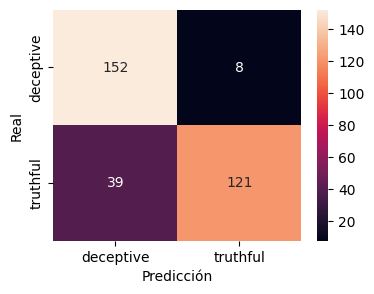

In [54]:
# creamos un diccionario con las etiquetas
data = {'y_Real':  y_test.to_numpy(),
        'y_Prediccion': predicciones['y_pred_30']
        }
# lo convertimos en un DataFrame de pandas
df = pd.DataFrame(data, columns=['y_Real','y_Prediccion'])

# hacemos una tabla crusada para obtener la matriz de confusión
confusion_matrix = pd.crosstab(df['y_Real'], df['y_Prediccion'],
                                rownames=['Real'], colnames=['Predicción'])

# realizamos un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

## Gráfica ROC
Area bajo la curva entre:

- True Positive Rate  (Sensitivity) :   Verdaderos Positivos / Positivos


- False Positive Rate (1-Specificity): Falsos Positivos / Negativos    


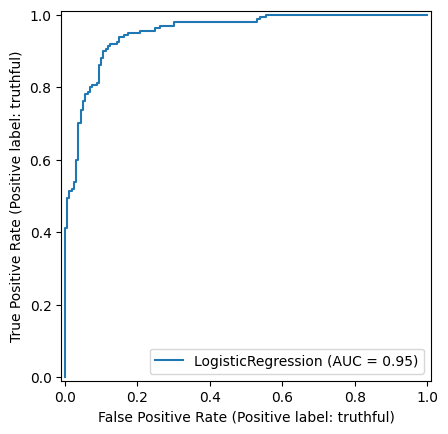

In [55]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(clasificador_ridge, X_test, y_test)
plt.show()

## Magnitud de los coeficientes para ambos modelos

In [56]:
clasificador_rl.coef_.shape

(1, 3278)

In [58]:
# Observa las magnitudes de los coeficientes del modelo
# sin y con regularización Ridge

coef_rl = pd.Series(
    clasificador_rl.coef_[0],
    index=features_names,
    name='SinRegularizacion'
    )
coef_ridge = pd.Series(
    clasificador_ridge.coef_[0],
    index=features_names,
    name='Ridge'
    )
coef = pd.concat([coef_rl, coef_ridge], axis=1)
coef.sort_values(by='Ridge', ascending=False)


,SinRegularizacion,Ridge
review,19.991777,4.674026
floor,19.112574,4.409130
confer,22.031542,4.357126
bathroom,19.796184,4.261099
call,20.931878,4.183137
...,...,...
food,-17.971253,-4.257513
relax,-18.264897,-4.460538
recent,-20.721619,-4.774858
luxuri,-26.386898,-6.505583


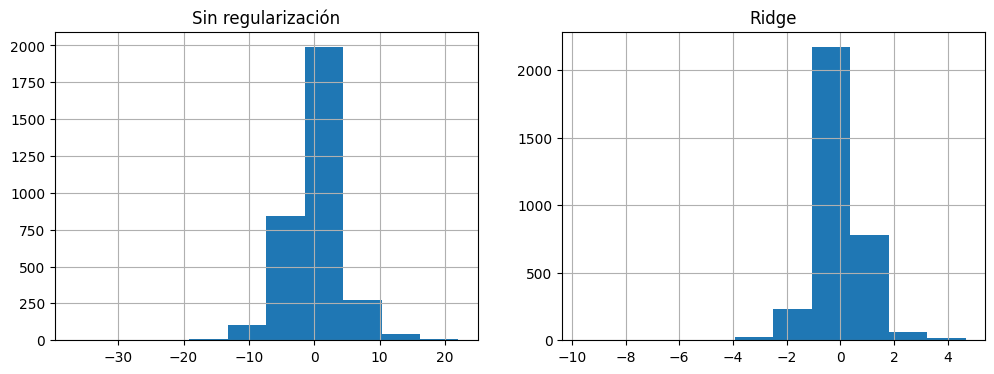

In [59]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))

coef['SinRegularizacion'].hist(ax=ax1)
ax1.set_title('Sin regularización')

coef['Ridge'].hist(ax=ax2)
ax2.set_title('Ridge')


plt.show()

In [60]:
# importancia de las palabras para predecir que es falsa la reseña
np.exp(coef).sort_values(by='Ridge', ascending=False)

,SinRegularizacion,Ridge
review,4.811922e+08,107.128148
floor,1.997493e+08,82.197932
confer,3.699789e+09,78.032569
bathroom,3.957066e+08,70.887862
call,1.231967e+09,65.571228
...,...,...
food,1.567415e-08,0.014157
relax,1.168574e-08,0.011556
recent,1.001648e-09,0.008439
luxuri,3.469892e-12,0.001495


# 7.Regresión Multiclase


In [84]:

y_train = df_train['deceptive'].str.cat(df_train['polarity'], sep='-')
y_test = df_test['deceptive'].str.cat(df_test['polarity'], sep='-')


In [74]:
clasificador_multiclase = LogisticRegression(penalty= None,
                                             random_state=4,
                                             max_iter=1500,        # Default 100
                                             tol=0.0001,           # Default 1e-4
                                             solver="sag").fit(X_train, y_train)
print("Exactitud en el conjunto de entrenamiento: ",
      clasificador_multiclase.score(X_train, y_train))
print("Exactitud en el conjunto de prueba: ",
      clasificador_multiclase.score(X_test, y_test))

Exactitud en el conjunto de entrenamiento:  1.0
Exactitud en el conjunto de prueba:  0.803125


In [75]:
%%time

grid_search = GridSearchCV(LogisticRegression(penalty='l2',solver="sag",
                                              max_iter=1500, tol=0.0001,
                                              warm_start=True),
                           {'C': 1/lambdas},
                           cv=kf,
                           return_train_score=False,
                           verbose=1
                           )
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 1min 17s, sys: 52.9 ms, total: 1min 17s
Wall time: 1min 15s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1500, solver='sag',
                                          warm_start=True),
             param_grid={'C': array([10.  ,  1.  ,  0.2 ,  0.1 ,  0.01])},
             verbose=1)

In [76]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,3.589212,0.448354,0.022471,0.004628,1.00,{'C': 1.0},0.851562,0.796875,0.777344,0.832031,0.832031,0.817969,0.026905,1
0,4.434975,0.284294,0.018885,0.000372,10.00,{'C': 10.0},0.863281,0.800781,0.750000,0.835938,0.828125,0.815625,0.038385,2
2,2.094542,0.347781,0.021206,0.005087,0.20,{'C': 0.2},0.828125,0.785156,0.750000,0.812500,0.816406,0.798438,0.028016,3
3,1.810352,0.145296,0.023421,0.006347,0.10,{'C': 0.1},0.839844,0.746094,0.726562,0.781250,0.808594,0.780469,0.040999,4
4,2.192767,0.594798,0.021876,0.006603,0.01,{'C': 0.01},0.500000,0.250000,0.488281,0.355469,0.707031,0.460156,0.153916,5


In [77]:
grid_search.best_params_['C']

np.float64(1.0)

In [78]:
clasificador_multiclase_ridge = LogisticRegression(penalty= 'l2',
                                        C = grid_search.best_params_['C'],
                                        random_state=5,
                                        solver="newton-cg").fit(X_train, y_train)
print("Exactitud en el conjunto de entrenamiento: ",
      clasificador_multiclase_ridge.score(X_train, y_train))
print("Exactitud en el conjunto de prueba: ",
      clasificador_multiclase_ridge.score(X_train, y_train))


Exactitud en el conjunto de entrenamiento:  0.98125
Exactitud en el conjunto de prueba:  0.98125


In [79]:
clasificador_multiclase_ridge.predict(X_test)

array(['truthful-negative', 'deceptive-positive', 'truthful-positive',
       'truthful-positive', 'truthful-negative', 'truthful-positive',
       'deceptive-positive', 'deceptive-negative', 'truthful-positive',
       'deceptive-negative', 'truthful-negative', 'truthful-positive',
       'truthful-negative', 'truthful-positive', 'truthful-negative',
       'deceptive-positive', 'truthful-positive', 'deceptive-positive',
       'deceptive-negative', 'truthful-negative', 'deceptive-negative',
       'truthful-negative', 'deceptive-negative', 'deceptive-positive',
       'deceptive-positive', 'deceptive-positive', 'deceptive-positive',
       'truthful-positive', 'deceptive-negative', 'deceptive-negative',
       'truthful-negative', 'deceptive-negative', 'truthful-negative',
       'deceptive-negative', 'truthful-negative', 'truthful-negative',
       'truthful-negative', 'truthful-positive', 'truthful-negative',
       'deceptive-positive', 'deceptive-positive', 'deceptive-positive',


In [80]:
clasificador_multiclase_ridge.classes_

array(['deceptive-negative', 'deceptive-positive', 'truthful-negative',
       'truthful-positive'], dtype=object)

In [81]:
clasificador_multiclase_ridge.predict_proba(X_test)

array([[0.30242209, 0.12336701, 0.47367468, 0.10053621],
       [0.20121013, 0.71587223, 0.04383418, 0.03908346],
       [0.05449688, 0.239142  , 0.08220814, 0.62415298],
       ...,
       [0.54255042, 0.04948377, 0.37444244, 0.03352337],
       [0.03670732, 0.33965644, 0.06398392, 0.55965232],
       [0.07983508, 0.68402746, 0.04261055, 0.19352691]])

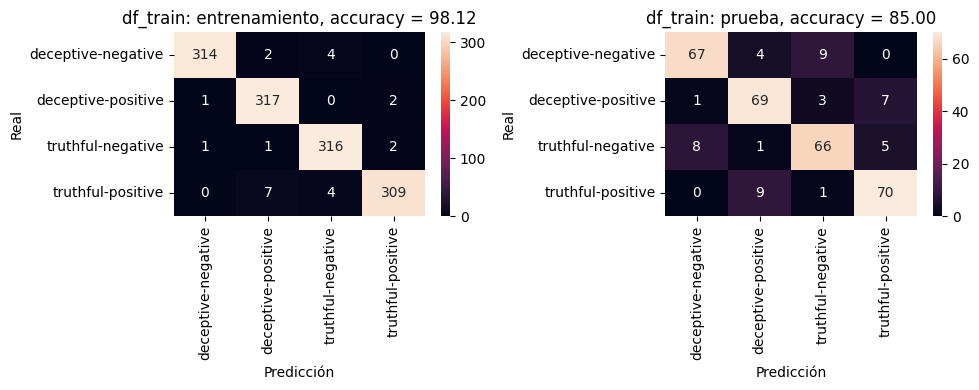

In [85]:
evaluacion(clasificador_multiclase_ridge)

In [86]:
clasificador_multiclase_ridge.coef_


array([[ 0.05209419, -0.0126575 , -0.15084056, ..., -0.07050311,
        -0.133175  , -0.05545878],
       [ 0.03120301,  0.02618398,  0.34328655, ...,  0.04450342,
        -0.04037045,  0.07225911],
       [-0.13433469, -0.13177331, -0.40777323, ..., -0.07426162,
         0.13675349,  0.0428914 ],
       [ 0.05103749,  0.11824683,  0.21532725, ...,  0.10026131,
         0.03679196, -0.05969173]])

# Recursos

Para profundizar en grid_search_cv

https://github.com/codebasics/py/blob/master/ML/15_gridsearch/15_grid_search.ipynb